In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

from tqdm import tqdm_notebook as tqdm

from ic_influence_maximization.generate_graph import generate_graph
from ic_influence_maximization.utils import pp, miia, mip, mioa, in_neighbors
from ic_influence_maximization.greedy_ic import naive_greedy_algorithm, ap
from ic_influence_maximization.pmia import pmia
from ic_influence_maximization.degreeHeuristic import degreeHeuristic

import time

theta =  0.01

## Time of execution with different number of nodes and constant number of seed nodes : 

In [ ]:
time_pmia=[]
time_maxdegree=[]
for i in range(10,200,20):
    graph = generate_graph(num_nodes_min_max=[i, i+5], directed=True, rate=0.6)
    start_time_pmia = time.time()
    path_pmia = pmia(graph, 5, theta, tqdm_function=tqdm)
    end_time_pmia = time.time()
    start_time_maxdegree =time.time()
    path_maxdegree=degreeHeuristic(graph, 5)
    end_time_maxdegree = time.time()
    time_pmia.append((start_time_pmia-end_time_pmia))
    time_maxdegree.append((start_time_maxdegree-end_time_maxdegree))

In [ ]:
n=range(10,200,20)
plt.plot(n,-np.array(time_pmia),'r')
plt.plot(n,-np.array(time_maxdegree),'b')
plt.show()

## Time of execution with constant number of nodes and different number of seed nodes : 

In [40]:
time_pmia_seeds=[]
time_maxdegree_seeds=[]
for i in range(1,10):
    graph = generate_graph(num_nodes_min_max=[10, 25], directed=True, rate=0.6) 
    start_time_pmia = time.time()
    path_pmia = pmia(graph, i, theta, tqdm_function=tqdm)
    end_time_pmia = time.time()
    start_time_maxdegree =time.time()
    path_maxdegree=degreeHeuristic(graph, i)
    end_time_maxdegree = time.time()
    time_pmia_seeds.append((start_time_pmia-end_time_pmia))
    time_maxdegree_seeds.append((start_time_maxdegree-end_time_maxdegree))

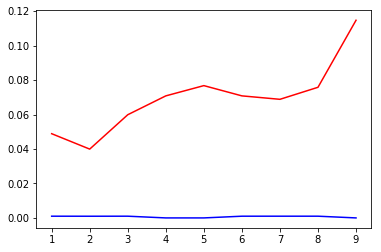

In [60]:
n=range(1,10)
plt.plot(n,-np.array(time_pmia_seeds),'r',label='pmia')
plt.plot(n,-np.array(time_maxdegree_seeds),'b',label='maxdegree')
plt.show()

## Comparison of Influence spread : 